In [1]:
PROJECT_ID = "datathon-484308" #@param {type:"string"}
DATASET_PROJECT_ID = 'amsterdamumcdb'
DATASET_ID = 'van_gogh_2026_datathon_update'
LOCATION = 'eu'

import os
from google.colab import auth
from google.cloud import bigquery

# Set environment variable for Google Cloud Project
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

print(f"Project ID set to: {PROJECT_ID}")
print(f"Dataset: {DATASET_PROJECT_ID}.{DATASET_ID} (Location: {LOCATION})")

#@title Authenticate User { display-mode: "form" }
auth.authenticate_user()
print('Successfully authenticated')

#@title Initialize Client { display-mode: "form" }
from google.cloud import bigquery

# Default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=f"{DATASET_PROJECT_ID}.{DATASET_ID}")

# Create the BigQuery client
client = bigquery.Client(project=PROJECT_ID, location=LOCATION, default_query_job_config=def_config)

# Enable data table display in Colab
%load_ext google.colab.data_table
from google.colab.data_table import DataTable
DataTable.max_columns = 50
DataTable.max_rows = 20000

print("BigQuery client initialized and ready.")

import pandas as pd
import pandas_gbq
import matplotlib.pyplot as plt
import numpy as np

config_gbq = {
    "query": {
        "defaultDataset": {"projectId": DATASET_PROJECT_ID, "datasetId": DATASET_ID},
        "location": LOCATION,
    }
}

src_config = f"{DATASET_PROJECT_ID}.{DATASET_ID}"

MY_NEW_DATASET_ID = "my_ventilation_study" #@param {type:"string"}
TABLE_VENTILATION_HOURS = f"{PROJECT_ID}.{MY_NEW_DATASET_ID}.ventilation_hours"
TABLE_EPISODES = f"{PROJECT_ID}.{MY_NEW_DATASET_ID}.ventilation_episodes"
TABLE_SERIES = f"{PROJECT_ID}.{MY_NEW_DATASET_ID}.ventilation_series"
TABLE_VENTILATION_OUTCOMES = f"{PROJECT_ID}.{MY_NEW_DATASET_ID}.ventilation_outcomes"
TABLE_WEANING_OUTCOMES = f"{PROJECT_ID}.{MY_NEW_DATASET_ID}.weaning_detailed_outcomes"

TABLE_DEATH  = f"{DATASET_PROJECT_ID}.{DATASET_ID}.death"
TABLE_VISIT  = f"{DATASET_PROJECT_ID}.{DATASET_ID}.visit_occurrence"

def q(sql: str) -> pd.DataFrame:
    return pandas_gbq.read_gbq(
        sql,
        project_id=PROJECT_ID,
        configuration=config_gbq,
        use_bqstorage_api=True,
    )

Project ID set to: datathon-484308
Dataset: amsterdamumcdb.van_gogh_2026_datathon_update (Location: eu)
Successfully authenticated
BigQuery client initialized and ready.


In [2]:
import pandas as pd
import numpy as np

# --- 1. Load Data ---
table_id = f"{PROJECT_ID}.{MY_NEW_DATASET_ID}.extubation_attempts_final_v4"
print(f"Loading data for audit from: {table_id}...")
df = client.query(f"SELECT * FROM `{table_id}`").to_dataframe()

# --- 2. Prepare Target Variable ---
# Definition: 1 = Failure (Re-intubation/Death), 0 = Success
df['target'] = df['detailed_outcome'].apply(lambda x: 1 if 'failure' in str(x).lower() else 0)

# --- 3. Define Feature Groups ---
# We use dynamic lookups to group the 50+ columns
feature_groups = {
    "Demographics": ['age_at_extubation', 'weight_kg', 'duration_hours'],
    "Vital_Signs_4h": [c for c in df.columns if any(x in c for x in ['_mean_4h', '_variability_4h', '_trend_4h'])],
    "Medication_Rates": [c for c in df.columns if c.startswith('rate_')],
    "Medication_Trends": [c for c in df.columns if c.startswith('trend_')],
    "Lab_Values": [c for c in df.columns if c.endswith('_last_48h')],
    "Fluids": ['urine_output_last_8h', 'fluid_balance_since_admission'],
    "Comorbidities": [c for c in df.columns if c.startswith('comm_')]
}

# --- 4. Build Analysis Table ---
analysis_rows = []

for group_name, cols in feature_groups.items():
    for col in cols:
        if col in df.columns:
            series = df[col]
            analysis_rows.append({
                "Group": group_name,
                "Parameter": col,
                "Missing (%)": (series.isnull().mean() * 100).round(1),
                "Mean": series.mean(),
                "Median": series.median(),
                "Min": series.min(),
                "Max": series.max(),
                "StdDev": series.std(),
                "Prevalence/Active (%)": ((series > 0.0001).mean() * 100).round(1) if group_name in ["Medication_Rates", "Comorbidities"] else "-"
            })

df_summary = pd.DataFrame(analysis_rows)

# --- 5. Output ---
print("\n--- COMPREHENSIVE FEATURE AUDIT ---")
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)
display(df_summary)

# --- 6. Quick Check: Target Distribution ---
n_success = (df['target'] == 0).sum()
n_failure = (df['target'] == 1).sum()
print(f"\n--- TARGET VARIABLE (EXTUBATION OUTCOME) ---")
print(f"Success: {n_success} ({n_success/len(df)*100:.1f}%)")
print(f"Failure: {n_failure} ({n_failure/len(df)*100:.1f}%)")

Loading data for audit from: datathon-484308.my_ventilation_study.extubation_attempts_final_v4...

--- COMPREHENSIVE FEATURE AUDIT ---


,Group,Parameter,Missing (%),Mean,Median,Min,Max,StdDev,Prevalence/Active (%)
0,Demographics,age_at_extubation,0.000,61.022,65.000,25.000,91.000,15.885,-
1,Demographics,weight_kg,11.600,72.794,70.000,40.000,100.000,13.094,-
2,Demographics,duration_hours,0.000,123.057,77.000,25.000,2348.000,132.967,-
3,Vital_Signs_4h,hr_mean_4h,0.500,114.806,112.625,22.500,325.000,21.510,-
4,Vital_Signs_4h,hr_variability_4h,0.000,21.567,18.398,0.000,110.657,14.579,-
5,Vital_Signs_4h,hr_trend_4h,5.900,1.410,1.500,-174.000,192.000,20.118,-
6,Vital_Signs_4h,sbp_mean_4h,1.400,63.228,61.750,11.000,320.000,13.658,-
7,Vital_Signs_4h,sbp_variability_4h,0.000,6.547,5.000,0.000,332.967,6.945,-
8,Vital_Signs_4h,sbp_trend_4h,7.900,0.926,1.000,-659.000,235.000,14.737,-
9,Vital_Signs_4h,spo2_mean_4h,0.900,85.581,85.000,-9.000,218.750,15.128,-



--- TARGET VARIABLE (EXTUBATION OUTCOME) ---
Success: 7512 (39.1%)
Failure: 11708 (60.9%)


In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# --- 1. Load Data ---
table_id = f"{PROJECT_ID}.{MY_NEW_DATASET_ID}.extubation_attempts_final_v4"
print(f"Loading Master Dataset from {table_id}...")
df = client.query(f"SELECT * FROM `{table_id}`").to_dataframe()

# --- 2. Preprocessing ---

# A. Target Definition
df['target'] = df['detailed_outcome'].apply(lambda x: 1 if 'failure' in str(x).lower() else 0)

# B. Feature Selection
# We exclude ID columns and the target itself
# We explicitly list the features to ensure order consistency
features = [
    # Demographics
    'age_at_extubation', 'weight_kg', 'duration_hours',

    # Vitals (Snapshot + Trends)
    'hr_mean_4h', 'hr_variability_4h', 'hr_trend_4h',
    'sbp_mean_4h', 'sbp_variability_4h', 'sbp_trend_4h',
    'spo2_mean_4h', 'spo2_trend_4h',
    'rr_mean_4h', 'rr_variability_4h', 'rr_trend_4h',

    # Medications (Rates + Trends) - Dynamic list based on your columns
    'rate_norepi', 'trend_norepi_4h',
    'rate_propofol', 'trend_propofol_4h',
    'rate_dobutamine', 'trend_dobutamine_4h',
    'rate_dopamine', 'trend_dopamine_4h',
    'rate_milrinone', 'trend_milrinone_4h',
    'rate_fentanyl', 'trend_fentanyl_4h',
    'rate_remifentanil', 'trend_remifentanil_4h',
    'rate_midazolam', 'trend_midazolam_4h',
    'rate_clonidine', 'trend_clonidine_4h',
    'rate_dexmedetomidine', 'trend_dexmedetomidine_4h',
    'rate_esketamine', 'trend_esketamine_4h',

    # Labs
    'hb_last_48h', 'crp_last_48h', 'lactate_last_48h', 'urea_last_48h', 'albumin_last_48h',

    # Fluids
    'urine_output_last_8h', 'fluid_balance_since_admission',

    # Comorbidities
    'comm_heart_vascular', 'comm_lung', 'comm_cerebral', 'comm_nch',
    'comm_abdomen', 'comm_renal', 'comm_oncology', 'comm_sepsis'
]

# Filter features that actually exist in the dataframe
features = [f for f in features if f in df.columns]

# C. Handling Missing Values (Smart Strategy)
# For Labs with high missingness, we add a binary flag "was_measured"
# This helps the model differentiate "Healthy (no lactate measured)" from "Sick (high lactate)"
high_missing_cols = ['lactate_last_48h', 'crp_last_48h', 'albumin_last_48h', 'pct_last_48h']
for col in high_missing_cols:
    if col in df.columns:
        # Create flag column
        df[f'{col}_missing'] = df[col].isnull().astype(int)
        features.append(f'{col}_missing')
        # We leave the NaN in the original column; XGBoost handles it.

X = df[features]
y = df['target']

Loading Master Dataset from datathon-484308.my_ventilation_study.extubation_attempts_final_v4...


In [4]:
# --- 3. Train/Test Split ---
# Stratified split to keep the success/failure ratio consistent
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calculate Scale Weight for Imbalance
# Ratio of Negative (0) to Positive (1) cases
neg_count, pos_count = np.bincount(y_train)
scale_weight = neg_count / pos_count

print(f"Training Set: {X_train.shape[0]} samples")
print(f"Test Set:     {X_test.shape[0]} samples")
print(f"Imbalance Ratio (Scale Weight): {scale_weight:.2f}")

# --- 4. XGBoost Model Training ---
model = xgb.XGBClassifier(
    n_estimators=300,           # Number of trees
    learning_rate=0.02,         # Slower learning for better generalization
    max_depth=6,                # Depth of trees
    subsample=0.8,              # Prevent overfitting
    colsample_bytree=0.8,       # Feature randomness
    scale_pos_weight=scale_weight, # Vital for imbalanced data!
    objective='binary:logistic',
    eval_metric='auc',
    early_stopping_rounds=30,   # Stop if validation doesn't improve
    random_state=42,
    n_jobs=-1
)

# We use a validation set inside the training to stop early if it overfits
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

print("\n--- Starting Training ---")
model.fit(
    X_train_part, y_train_part,
    eval_set=[(X_val, y_val)],
    verbose=50
)

Training Set: 15376 samples
Test Set:     3844 samples
Imbalance Ratio (Scale Weight): 0.64

--- Starting Training ---
[0]	validation_0-auc:0.63749
[50]	validation_0-auc:0.70076
[100]	validation_0-auc:0.70510
[150]	validation_0-auc:0.71144
[200]	validation_0-auc:0.71359
[250]	validation_0-auc:0.71640
[299]	validation_0-auc:0.71624


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)


FINAL RESULTS (Test Set)
ROC AUC:            0.7121 (Baseline: 0.5)
Average Precision:  0.7963  (Baseline: 0.6092)
----------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.68      0.60      1502
           1       0.75      0.62      0.68      2342

    accuracy                           0.64      3844
   macro avg       0.64      0.65      0.64      3844
weighted avg       0.67      0.64      0.65      3844


Calculating SHAP values...


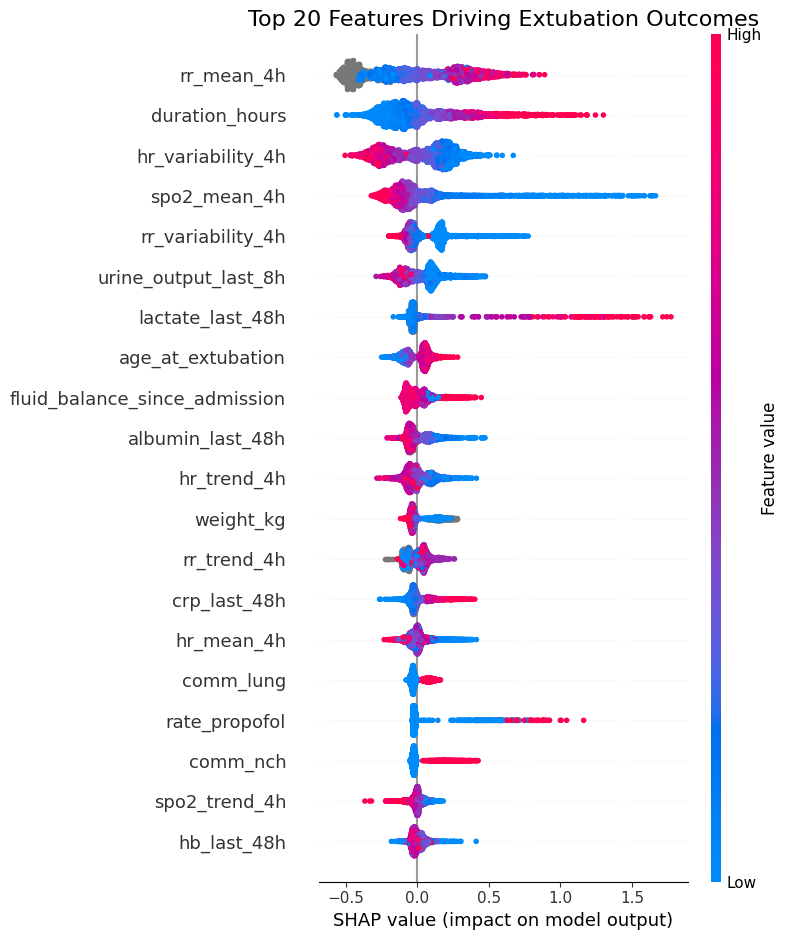

In [5]:
# --- 5. Evaluation ---
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred_class = (y_pred_prob > 0.5).astype(int) # Default threshold

auc = roc_auc_score(y_test, y_pred_prob)
ap = average_precision_score(y_test, y_pred_prob)

print("\n" + "="*40)
print(f"FINAL RESULTS (Test Set)")
print("="*40)
print(f"ROC AUC:            {auc:.4f} (Baseline: 0.5)")
print(f"Average Precision:  {ap:.4f}  (Baseline: {y.mean():.4f})")
print("-" * 40)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))

# --- 6. SHAP Explainability (The "Why") ---
# This takes a minute but gives the best insights
print("\nCalculating SHAP values...")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, max_display=20, show=False)
plt.title("Top 20 Features Driving Extubation Outcomes", fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
import numpy as np
import shap
from scipy.stats import pearsonr

# --- 1. Safety Check: Get SHAP values ---
# If you haven't calculated them yet, we do it here.
if 'shap_values' not in locals():
    print("Recalculating SHAP values...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
else:
    print("Using existing SHAP values.")

# --- 2. Build the Risk Analysis Table ---
feature_names = X_test.columns
shap_abs_mean = np.abs(shap_values).mean(axis=0)

# Prepare data for comparison
df_analysis = X_test.copy()
# Reset index to ensure alignment if X_test was shuffled/split
df_analysis = df_analysis.reset_index(drop=True)
outcomes = y_test.values

results = []

for i, col in enumerate(feature_names):
    # A. Importance
    importance = shap_abs_mean[i]

    # B. Direction (Correlation)
    try:
        corr, _ = pearsonr(df_analysis[col], shap_values[:, i])
    except:
        corr = 0

    if corr > 0:
        pattern = "HIGH = RISK" # Higher value -> Higher failure probability
    else:
        pattern = "LOW = RISK"  # Lower value -> Higher failure probability

    # C. Clinical Averages
    # We compare the average value of this feature for patients who failed vs succeeded
    avg_fail = df_analysis.loc[outcomes == 1, col].mean()
    avg_succ = df_analysis.loc[outcomes == 0, col].mean()

    results.append({
        'Feature': col,
        'Importance': importance,
        'Risk_Pattern': pattern,
        'Avg_Failure': avg_fail,
        'Avg_Success': avg_succ
    })

# --- 3. Display the Table ---
df_risk = pd.DataFrame(results)
df_risk = df_risk.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print(f"\n--- TOP 20 RISK FACTORS FOR EXTUBATION FAILURE ---")
print(f"(Based on {len(X_test)} test cases)\n")

# Apply styling
format_dict = {
    'Importance': '{:.4f}',
    'Avg_Failure': '{:.3f}',
    'Avg_Success': '{:.3f}'
}

display(df_risk.head(20).style.format(format_dict).background_gradient(subset=['Importance'], cmap='Reds'))


Using existing SHAP values.

--- TOP 20 RISK FACTORS FOR EXTUBATION FAILURE ---
(Based on 3844 test cases)



/tmp/ipython-input-1192980872.py:33: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(df_analysis[col], shap_values[:, i])


,Feature,Importance,Risk_Pattern,Avg_Failure,Avg_Success
0,rr_mean_4h,0.3009,LOW = RISK,23.378,21.670
1,duration_hours,0.2079,HIGH = RISK,138.763,100.857
2,hr_variability_4h,0.1974,LOW = RISK,20.032,23.924
3,spo2_mean_4h,0.1794,LOW = RISK,83.306,88.958
4,rr_variability_4h,0.1106,LOW = RISK,5.156,4.532
5,urine_output_last_8h,0.1073,LOW = RISK,520.854,514.015
6,lactate_last_48h,0.0748,LOW = RISK,2.240,1.331
7,age_at_extubation,0.0736,HIGH = RISK,61.886,58.967
8,fluid_balance_since_admission,0.0688,LOW = RISK,-6058.521,-4184.138
9,albumin_last_48h,0.0677,LOW = RISK,22.284,24.754


<Figure size 1000x600 with 0 Axes>

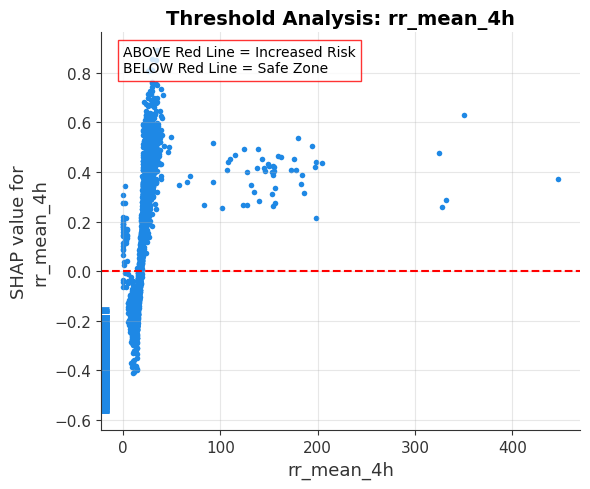

<Figure size 1000x600 with 0 Axes>

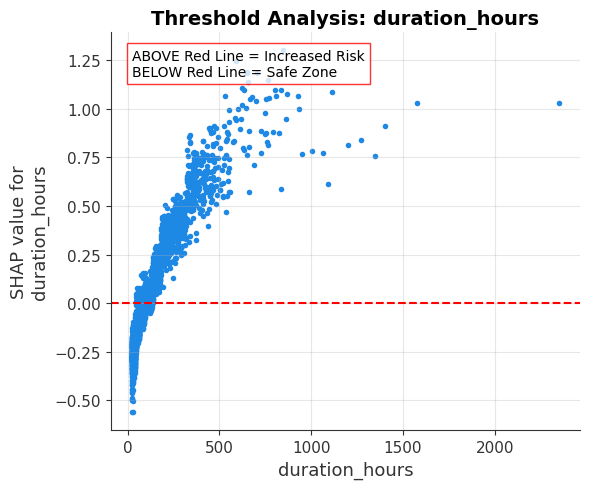

<Figure size 1000x600 with 0 Axes>

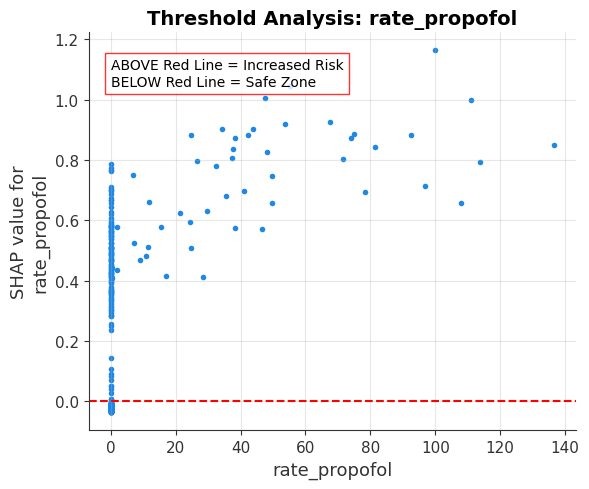

<Figure size 1000x600 with 0 Axes>

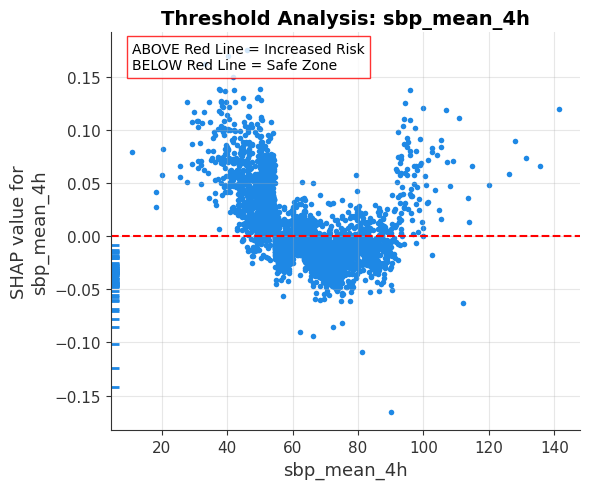

<Figure size 1000x600 with 0 Axes>

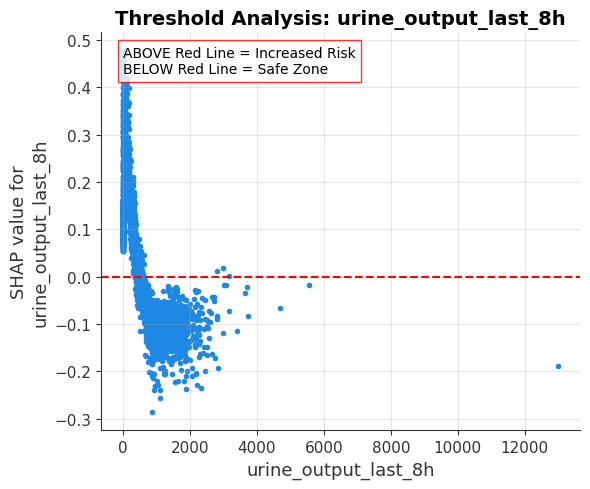

In [9]:
import matplotlib.pyplot as plt
import shap
import numpy as np

# --- Configuration ---
# Select the features you want to find thresholds for.
# I included the top drivers from your list + Blood Pressure (as requested)
features_to_analyze = [
    'rr_mean_4h',          # Top Feature: Respiratory Rate
    'duration_hours',      # Top Feature: Duration of Ventilation
    'rate_propofol',       # Sedation dosage
    'sbp_mean_4h',         # Systolic Blood Pressure (Specific request)
    'urine_output_last_8h' # Kidney function
]

# --- Plotting Loop ---
for feature in features_to_analyze:
    # Verify feature exists in the model
    if feature in X_test.columns:
        plt.figure(figsize=(10, 6))

        # Create Dependence Plot
        # interaction_index=None removes the color coding to focus purely on the threshold curve
        shap.dependence_plot(
            feature,
            shap_values,
            X_test,
            display_features=X_test,
            interaction_index=None,
            show=False # Allows us to customize the plot
        )

        # Add the "Neutral Line" (Threshold)
        plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
        plt.title(f"Threshold Analysis: {feature}", fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)

        # Add explanatory annotation
        y_max = np.max(shap_values[:, X_test.columns.get_loc(feature)])
        x_min = X_test[feature].min()

        plt.text(
            x=x_min,
            y=y_max * 0.9,
            s="ABOVE Red Line = Increased Risk\nBELOW Red Line = Safe Zone",
            bbox=dict(facecolor='white', edgecolor='red', alpha=0.8),
            fontsize=10
        )

        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ Feature '{feature}' not found in the test set. Check column names.")